# Convolutional Neural Network Training

Author: Zhongyi (James) Guo, Tiankai Yan <br>
Date: 11/07/2024

## Import Packages

In [1]:
# system
import os
import pickle
import gzip

# data manipulation
import pandas as pd
import numpy as np

# deep learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-11-15 04:38:34.036178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 04:38:34.052591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731645514.072554    2171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731645514.078599    2171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 04:38:34.099253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
os.getcwd()

'/home/ubuntu/SCA-DL-DGE/script/cnn'

## Import Dataset

In [3]:
with gzip.open('../../result/one_hot_encoding/gene_id_label_ohe.pkl.gz', 'rb') as f:
    data = pickle.load(f)

In [4]:
data

,ensembl_gene_id,DE,upstream_region_encoded
0,ENSG00000000457,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
1,ENSG00000000460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,..."
2,ENSG00000000938,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,ENSG00000000971,1,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
4,ENSG00000001460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
...,...,...,...
55221,ENSG00000284520,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1,..."
55222,ENSG00000284544,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
55223,ENSG00000284554,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
55224,ENSG00000284568,0,"[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."


## Quality Control

In [5]:
X = np.stack(data['upstream_region_encoded'].values)
Y = data['DE'].values

In [6]:
print(X.shape)
print(Y.shape)

(55223, 2000, 4)
(55223,)


In [7]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
data['DE'].value_counts()

DE
0    51097
1     4126
Name: count, dtype: int64

The labels are imbalanced.

## Train-test Split

In [9]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123)

In [10]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(44178, 2000, 4)
(11045, 2000, 4)
(44178,)
(11045,)


We need to add one more channel to train CNN.

In [11]:
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1) 

In [12]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(44178, 2000, 4, 1)
(11045, 2000, 4, 1)
(44178,)
(11045,)


Hyperparameters:

In [13]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
EPOCH_SIZE = 20

Shuffle the dataset and apply mini-batch gradient descent with a batch size of 256:

In [14]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dev = tf.data.Dataset.from_tensor_slices((X_dev, Y_dev)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1731645525.953856    2171 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [15]:
for batch in train.take(1):  
    X_batch, Y_batch = batch
    print("X_batch:", X_batch.shape) 
    print("Y_batch:", Y_batch.shape)

X_batch: (256, 2000, 4, 1)
Y_batch: (256,)


2024-11-15 04:38:52.345362: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
num_batches = 0
for _ in train:
    num_batches += 1
print("Number of mini-batches:", num_batches)

Number of mini-batches: 173


2024-11-15 04:38:52.892572: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Building

In [17]:
model = models.Sequential()
model.add(layers.Input(shape=(2000, 4, 1), batch_size = BATCH_SIZE))
# Batch normalization (optional)
model.add(layers.Conv2D(16, (2, 2), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same'))
# Batch normalization (optional)
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# model = models.Sequential()
# model.add(layers.Input(shape=(2000, 4, 1), batch_size=BATCH_SIZE))
# model.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2), padding='same'))

# model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
# model.add(layers.Dropout(0.5))

# model.add(layers.GlobalMaxPooling2D())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (256, 2000, 4, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (256, 1000, 2, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (256, 1000, 2, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (256, 500, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (256, 32)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (256, 64)              │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (256, 1)               │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,337 (16.94 KB)

 Trainable params: 4,337 (16.94 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## Model Fitting

In [20]:
history = model.fit(
    train,                  
    epochs=EPOCH_SIZE,        
    validation_data=dev     
)

Epoch 1/20


I0000 00:00:1731645534.647604    2229 service.cc:148] XLA service 0x7f6cd801b890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731645534.648034    2229 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-15 04:38:54.700562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731645534.900253    2229 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-15 04:38:56.169937: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-11-15 04:38:56.169984: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:877] Conv: %cudnn-conv.6 = (f32[16,32,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,256,1001,3]{3,2,1,0} %bitcast.1523, f32[32,256,1000,2]{3,2,1,0} %bitcas

  1/173 ━━━━━━━━━━━━━━━━━━━━ 13:47 5s/step - accuracy: 0.9492 - loss: 0.6523

I0000 00:00:1731645538.324544    2229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9246 - loss: 0.3488

2024-11-15 04:39:07.571273: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-11-15 04:39:07.571306: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:877] Conv: %cudnn-conv.6 = (f32[16,32,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,146,1001,3]{3,2,1,0} %bitcast.1523, f32[32,146,1000,2]{3,2,1,0} %bitcast.1525), window={size=1000x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/sequential_1/conv2d_1_2/convolution/Conv2DBackpropFilter" source_file="/home/ubuntu/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_sc

173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9246 - loss: 0.3482 - val_accuracy: 0.9290 - val_loss: 0.2563
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9243 - loss: 0.2683 - val_accuracy: 0.9290 - val_loss: 0.2575
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9227 - loss: 0.2721 - val_accuracy: 0.9290 - val_loss: 0.2559
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9240 - loss: 0.2685 - val_accuracy: 0.9290 - val_loss: 0.2558
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9259 - loss: 0.2638 - val_accuracy: 0.9290 - val_loss: 0.2561
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9258 - loss: 0.2639 - val_accuracy: 0.9290 - val_loss: 0.2577
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9243 - loss: 0.2674 - val_accuracy: 0.9290 - val_loss: 0.2559
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9242 - loss: 0.2673 - val_accuracy: 0.92

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9197 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.9221 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.9230 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9232 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9231 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9232 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9232 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9229 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9227 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.9226 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9225 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.9224 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.9222 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.9221 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.9220 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9222 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9221 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9222 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9222 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9222 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9222 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9222 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9223 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9223 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9222 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9223 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9223 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9223 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.9223 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9224 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9224 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9224 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9225 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9225 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9225 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9226 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9226 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9227 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9228 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9228 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9229 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9229 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.9230 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9230 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9231 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9232 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9231 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9232 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9232 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9232 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9233 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9233 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9234 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9234 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9234 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9235 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9235 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9236 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9237 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9238 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9238 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9239 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9239 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9239 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9240 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9240 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9240 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9240 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9240 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9241 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9241 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9241 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9241 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9241 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9241 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9242 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9242 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9242 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9242 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9242 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9242 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9242 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9242 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9242 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9242 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9243 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9243 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9243 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9243 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9243 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9243 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9243 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9243 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9244 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9244 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9244 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9244 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9244 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9244 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9244 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9244 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9244 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9245 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9245 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9245 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9245 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9245 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9245 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9245 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9245 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9245 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9245 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9245 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9245 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9245 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9245 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9245 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9245 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9245 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.9245 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 2/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - accuracy: 0.9141 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.9160 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9167 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9170 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9173 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9186 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9190 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9190 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9192 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9194 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9194 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9191 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9190 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9190 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9190 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9190 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9190 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9190 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9190 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9191 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9191 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9191 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9192 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9192 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9193 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9194 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9194 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9194 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9195 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9196 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9196 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9196 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9197 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9197 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9197 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9198 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9199 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9199 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9199 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9199 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9200 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9200 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9201 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9201 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9201 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9202 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9202 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9203 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9203 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9204 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9204 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9205 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9207 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9206 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9207 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9208 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9208 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9208 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9208 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9209 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9209 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9209 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9209 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9209 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9210 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9210 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9210 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9210 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9211 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9211 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9211 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9211 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9211 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9212 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9212 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9212 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9212 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9212 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9213 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9213 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9213 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9213 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9214 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9214 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9214 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9214 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9214 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9214 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9215 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9215 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9215 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9216 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9216 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9216 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9216 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9217 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9217 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9217 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9217 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9217 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9218 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9218 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9218 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9218 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9219 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9219 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9219 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9219 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9220 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9220 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9220 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9220 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9220 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9220 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9221 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9221 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9221 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9221 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9221 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9222 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9222 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9222 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9223 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9223 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9223 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9223 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9223 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9223 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9223 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9224 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9224 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 3/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 191ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9258 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9266 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9263 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9247 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9249 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9249 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9249 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9248 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9246 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9244 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9244 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9244 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9243 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9241 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9241 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9242 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9240 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9239 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9238 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9236 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9236 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9235 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9234 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9233 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9232 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9232 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9232 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9231 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9231 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9230 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9230 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.9230 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9230 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9230 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9230 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9229 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9230 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9229 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9229 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9229 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9229 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9229 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9229 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9228 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9228 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9228 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9228 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9228 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9228 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9228 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9228 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9228 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9228 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9228 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9228 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9228 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9228 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9228 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9228 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9228 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9228 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9228 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9228 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9228 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9228 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9228 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9228 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9228 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9228 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9228 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9228 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9228 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9228 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9228 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9228 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9228 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9228 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9228 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9228 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9228 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9228 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9228 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9228 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9228 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9228 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9228 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9228 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9228 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9228 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9228 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9229 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9229 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9229 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9229 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9229 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9229 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9229 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 4/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.9062 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9121 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9128 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9128 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9127 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.9160 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9174 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9178 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9182 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9181 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9183 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9184 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9186 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9188 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9189 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9191 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9192 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9193 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9193 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9194 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9196 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9195 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9196 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9198 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9199 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9200 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9201 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9202 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9204 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9206 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9208 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9207 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9209 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9209 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9210 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9210 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9211 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9212 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9213 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9213 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9215 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9215 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9216 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9216 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9216 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9216 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9217 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9217 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9217 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9217 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9217 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9218 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9218 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9218 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9219 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9218 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9219 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9219 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9220 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9220 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9220 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9220 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9220 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9220 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9220 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9220 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9221 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9221 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9221 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9221 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9221 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9221 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9221 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9221 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9221 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9222 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9222 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9222 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9222 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9223 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9223 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9224 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9224 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9224 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9224 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9224 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9224 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9225 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9225 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9225 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9225 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9225 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9226 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9226 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9226 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9226 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9226 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9227 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9227 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9227 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9227 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9227 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9228 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9228 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9229 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9229 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9230 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 5/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.9492 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9346 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9282 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9239 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9207 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9186 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9172 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9156 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9151 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9154 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9150 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9143 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9141 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9140 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9140 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9140 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9141 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9143 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9144 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9147 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9148 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9149 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9151 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9152 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9153 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9156 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9157 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9159 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9160 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9162 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9163 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9164 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9166 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9168 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9172 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9173 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9174 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9178 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9177 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9179 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9180 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9182 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9182 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9183 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9184 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9184 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9185 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9185 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9186 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9187 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9186 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9188 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9189 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9189 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9190 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9190 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9191 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9192 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9192 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9193 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9193 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9194 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9194 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9194 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9195 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9197 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9198 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9199 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9200 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9199 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9200 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9201 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9201 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9202 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9202 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9202 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9203 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9203 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9204 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9204 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9204 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9205 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9205 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9206 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9206 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9207 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9208 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9208 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9209 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9209 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9209 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9210 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9210 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9211 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9211 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9211 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9212 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9212 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9213 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9213 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9213 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9214 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9213 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9214 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9214 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9215 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9215 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9215 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9216 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9216 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9216 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9216 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9217 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9217 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9217 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9218 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9218 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9218 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9218 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9219 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9219 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9219 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9219 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9220 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9220 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9220 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9220 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9220 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9220 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9220 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9221 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9221 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9221 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9221 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9221 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9221 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9221 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9222 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9222 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9222 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9222 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9222 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9222 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 6/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.9141 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9160 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9128 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9119 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9121 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9131 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9144 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9151 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9155 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9158 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9166 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9170 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9175 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9189 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9186 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9193 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9198 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9195 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9202 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9205 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9208 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9207 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9210 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9213 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9214 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9214 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9216 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9217 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9220 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9219 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9221 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9223 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9224 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9225 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9225 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9227 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9228 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9230 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9232 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9232 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9232 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9233 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9233 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9233 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9233 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9234 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9234 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9234 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9235 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9235 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9236 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9236 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9236 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9236 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9237 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9238 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9239 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9239 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9239 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9240 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9240 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9240 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9240 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9240 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9240 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9240 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9240 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9241 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9241 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9241 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9241 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9241 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9241 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9241 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9241 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9241 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9241 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9241 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9241 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9241 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9241 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9241 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9241 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9241 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9241 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9241 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9242 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9242 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9242 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9242 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9242 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9242 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9242 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9242 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9242 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9242 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9242 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9242 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9242 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9242 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9242 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9242 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9242 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9242 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9242 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9242 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9242 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9242 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9242 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9242 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 7/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.9062 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9102 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9149 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9174 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9191 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9213 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9223 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9237 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9243 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9259 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9254 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9261 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9263 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9264 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9265 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9266 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9266 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9267 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9266 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9269 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9270 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9270 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9270 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9271 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9271 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9271 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9272 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9272 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9272 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9273 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9273 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9273 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9273 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9273 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9273 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9273 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9272 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9272 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9272 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9271 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9271 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9271 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9271 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9271 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9271 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9271 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9271 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9270 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9271 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9270 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9270 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9270 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9270 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9270 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9269 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9269 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9269 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9269 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9269 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9269 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9269 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9268 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9268 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9268 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9268 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9268 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9268 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9268 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9268 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9268 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9268 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9268 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9268 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9267 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9267 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9267 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9267 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9267 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9266 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9265 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9265 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9265 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9265 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9264 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9264 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9264 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9264 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9264 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9264 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9263 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9263 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9263 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9263 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9263 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9262 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9262 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9262 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9262 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9262 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9262 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9262 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9262 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9261 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9261 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9261 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9261 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9261 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9261 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9261 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9260 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9260 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9260 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9260 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9260 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9260 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9260 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9260 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9260 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9259 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9259 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9259 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9259 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9259 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9258 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 8/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9297 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9323 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9314 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9284 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9279 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9276 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9274 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9270 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9261 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9251 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9247 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9245 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9246 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9242 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9243 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9241 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9239 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9239 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9239 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9239 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9238 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9237 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9237 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9236 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9236 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9235 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9234 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9233 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9233 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9231 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9232 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9231 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9230 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9230 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9229 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9228 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9228 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9228 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9228 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9227 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9227 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9227 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9227 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9226 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9226 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9226 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9226 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9227 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9227 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9227 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9227 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9227 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9227 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9227 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9227 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9228 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9228 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9228 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9228 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9228 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9228 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9228 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9228 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9229 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9229 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9229 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9229 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9229 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9230 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9230 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9230 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9230 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9230 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9230 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9230 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9231 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9231 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9231 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9231 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9232 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9231 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9232 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9232 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9232 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9232 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9232 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9232 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9232 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9233 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9233 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9233 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9233 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9233 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9233 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9233 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9234 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9234 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9234 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9234 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9234 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9234 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9234 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9234 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9234 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9234 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9234 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9234 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9234 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9234 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9234 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9235 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9235 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9235 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9235 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9235 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9235 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9235 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9235 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9235 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9235 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9235 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9235 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9235 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9235 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9235 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 9/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9287 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9282 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9264 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9250 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9234 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.9231 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9233 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9233 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9232 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9235 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9236 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9238 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9242 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.9248 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9251 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9252 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9255 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9254 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9254 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9256 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9256 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9256 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9257 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9257 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9258 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9258 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9258 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9259 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9261 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9261 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9262 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9262 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9262 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9262 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9262 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9262 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9261 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9261 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9261 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9261 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9260 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9260 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9260 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9260 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9259 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9259 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9259 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9259 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9259 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9258 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9258 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9258 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9258 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9258 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9258 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9257 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9257 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9257 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9257 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9256 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9256 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9256 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9256 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9256 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9256 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9256 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9255 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9256 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9255 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9255 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9255 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9255 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan 

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan 

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9253 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9252 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9252 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9252 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9252 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9252 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9252 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9252 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9252 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9252 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9252 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9252 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9252 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9252 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9252 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9252 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9252 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9251 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9251 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9251 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9251 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9251 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9251 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9251 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9251 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9251 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9251 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9251 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9251 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9251 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9251 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9251 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9251 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 10/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.8672 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.8789 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.8872 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.8974 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9018 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9003 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9032 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9074 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9064 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9104 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9112 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9120 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9140 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9127 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.9146 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9156 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9170 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9177 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9175 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9179 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9182 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9184 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9188 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9192 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9190 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9194 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9195 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9197 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9199 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9200 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9201 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9203 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9202 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9204 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9206 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9207 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9208 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9208 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9210 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9211 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9212 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9212 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9214 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9215 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9215 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9217 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9218 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9218 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9219 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9219 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9220 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9220 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9220 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9220 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9221 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9221 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9221 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9222 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9222 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9222 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9222 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9222 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9222 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9222 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9222 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9222 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9222 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9223 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9223 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9223 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9223 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9223 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9223 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9223 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9223 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9223 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9223 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9223 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9223 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9223 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9223 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9223 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9223 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9223 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9223 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9223 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9223 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9223 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9223 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9223 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9223 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9223 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9223 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9223 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9223 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9223 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9223 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9223 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9224 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9224 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9224 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9224 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9224 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9224 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9224 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9224 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9224 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9225 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9224 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9225 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9225 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9225 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9225 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9225 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9225 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9226 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9226 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9226 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9226 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 11/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9287 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9269 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9261 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9252 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9245 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9240 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9239 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9235 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9234 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9235 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9235 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9237 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9236 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9239 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9241 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9243 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9245 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9246 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9248 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9248 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9249 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9249 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9251 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9251 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9251 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9251 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9251 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9251 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9251 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9251 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9250 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9250 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9249 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9249 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9249 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9249 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9249 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9249 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9249 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9249 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9249 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9249 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9249 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9250 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9250 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9250 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9250 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9250 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9250 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9250 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9250 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9250 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9250 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9250 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9251 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9251 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9251 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9251 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9251 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9251 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9251 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9252 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9252 - loss: nan 

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9252 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9252 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9252 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9252 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9252 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9252 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9252 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9252 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9253 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9253 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9253 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9253 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9253 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9253 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9253 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9253 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9252 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9253 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9252 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9252 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9252 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9252 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9252 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9252 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9252 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9252 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9252 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9252 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9252 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9252 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9252 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9252 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9252 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9252 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 12/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.9180 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.9199 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9219 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9231 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9235 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9231 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9227 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9217 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9223 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9216 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9215 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9215 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9217 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9218 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9221 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9221 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9223 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9225 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9226 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9226 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9226 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9226 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9226 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9226 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9227 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9227 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9228 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9229 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9229 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9229 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9230 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9231 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9233 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9233 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9233 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9234 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9234 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9235 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9237 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9236 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9237 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9237 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9238 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9238 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9239 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9239 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9239 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9240 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9240 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9240 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9241 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9241 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9242 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9242 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9242 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9242 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9242 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9243 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9243 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9243 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9243 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9243 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9243 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9243 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9243 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9243 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9243 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9243 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9243 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9243 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9243 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9243 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9243 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9243 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9243 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9243 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9243 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9243 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9243 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9243 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9243 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9243 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9243 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9243 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9243 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9243 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9243 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9243 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9243 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9243 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9243 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9243 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9243 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9243 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9243 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9243 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9243 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9243 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9243 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9243 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9243 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9243 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9243 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9243 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9243 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9243 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9243 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9243 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9243 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9243 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9243 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9243 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 13/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.9414 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.9277 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9268 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9267 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9261 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9256 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9255 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9254 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9254 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9255 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9256 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9256 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9257 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9257 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9258 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9259 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9259 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9259 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9259 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9259 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9259 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9259 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9258 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9258 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9257 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9257 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9256 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9256 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9256 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9255 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9254 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9254 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9253 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9252 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9252 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9251 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9250 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9250 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9248 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9249 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9248 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9247 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9247 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9247 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9246 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9246 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9246 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9245 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9245 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9245 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9245 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9244 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9244 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9244 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9244 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9244 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9244 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9244 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9244 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9244 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9243 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9243 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9243 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9243 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9243 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9243 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9243 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9242 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9243 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9242 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9242 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9242 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9242 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9242 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9242 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9241 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9241 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9241 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9241 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9241 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9241 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9241 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9241 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9241 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9241 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9241 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9241 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9241 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9241 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9241 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9241 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9241 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9241 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9241 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9241 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9241 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9241 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9241 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9241 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9241 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9241 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 14/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9453 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.9336 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9280 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9235 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9205 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9203 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9203 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9205 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9211 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9214 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9216 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9219 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9223 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9227 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9230 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9232 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9233 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9237 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9239 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9242 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9240 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9244 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9244 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9245 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9245 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9245 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9245 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9245 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9246 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9246 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9246 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9247 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9247 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9248 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9249 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9249 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9249 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9250 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9250 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9250 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9251 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9251 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9251 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9252 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9252 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9253 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9253 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9253 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9253 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9253 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9254 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9253 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9254 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9254 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9255 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9255 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9256 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9256 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9256 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9256 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9256 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9256 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9256 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9256 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9257 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9257 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9257 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9257 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9258 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9257 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9258 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9258 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9258 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9258 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9258 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9258 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9258 - loss: nan 

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9258 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9258 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9258 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9258 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9258 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9258 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9258 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9258 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9258 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9258 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9258 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9258 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9258 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9258 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9258 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9258 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9258 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9258 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9258 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9258 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9258 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9257 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9258 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9257 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9257 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9257 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9257 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9257 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9257 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9257 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9257 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9257 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9257 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9257 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9257 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9257 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9257 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9257 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9256 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9256 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9256 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9256 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9256 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9256 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 15/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9229 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9204 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9215 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9220 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9227 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9234 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9252 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9243 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9266 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9269 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9273 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9275 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9277 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9280 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9281 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9286 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9284 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9288 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9289 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9290 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9291 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9291 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9292 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9293 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9293 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9294 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9295 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9295 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9294 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9294 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9292 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9292 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9291 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9290 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9290 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9288 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9287 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9287 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9286 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9284 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9283 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9281 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9280 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9279 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9280 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9278 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9278 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9277 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9277 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9276 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9276 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9275 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9275 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9274 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9275 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9274 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9273 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9274 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9273 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9273 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9273 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9272 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9272 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9272 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9272 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9272 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9271 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9271 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9271 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9271 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9269 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9269 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9269 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9268 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9269 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9268 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9267 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9267 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9267 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9266 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9265 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9265 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9264 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9264 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9264 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9263 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9263 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9263 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9263 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9263 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9263 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9263 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9263 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9263 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9263 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9263 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9263 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9263 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9262 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9262 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9262 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9262 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9262 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9262 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9262 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9262 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9262 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9262 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9261 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9261 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9261 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9261 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9261 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9261 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9260 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9260 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9260 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9260 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9260 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9260 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 16/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.9336 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9307 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9273 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9274 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.9280 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9283 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9285 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9281 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9275 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9271 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9266 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9260 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9264 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9260 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9259 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9260 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9260 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9260 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9260 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9260 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9260 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9259 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9259 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9257 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9258 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9256 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9257 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9255 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9255 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9254 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9254 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9253 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9252 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9253 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9251 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9251 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9250 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9249 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9250 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9248 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9247 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9246 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9246 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9245 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9244 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9243 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9243 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9243 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9243 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9242 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9242 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9242 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9240 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9240 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9240 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9240 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9240 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9240 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9240 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9240 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9240 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9240 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9240 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9240 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9240 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9240 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9241 - loss: nan 

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9241 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9241 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9241 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9241 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9241 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9241 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9241 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9241 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9241 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9241 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9240 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9240 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9240 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9240 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9240 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9240 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9240 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9240 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9240 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9240 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9240 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9240 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9240 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9240 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9240 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9239 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9239 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9239 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9239 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9239 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9239 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 17/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.9414 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9404 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9386 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9351 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9313 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9311 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9312 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9311 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9310 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9308 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9301 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9296 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9289 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9292 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9285 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9282 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9283 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9281 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9279 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9278 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9279 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9275 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9274 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9273 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9272 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9269 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9266 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9267 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9265 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9263 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9264 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9262 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9261 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9260 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9261 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9260 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9259 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9258 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9257 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9256 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9256 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9256 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9255 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9255 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9254 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9254 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9253 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9253 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9253 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9253 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9252 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9252 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9252 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9252 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9252 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9252 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9252 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9252 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9252 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9252 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9252 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9252 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9252 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9252 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9252 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9252 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9252 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9252 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9253 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9253 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9253 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9253 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9253 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9253 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9253 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9253 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9253 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9253 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9253 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9253 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9254 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9254 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9254 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9254 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9255 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9255 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9255 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9255 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9255 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9255 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9255 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9255 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9256 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9256 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9256 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9256 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9256 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9256 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9256 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9256 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9256 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9256 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9256 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9256 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9256 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9256 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9256 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9256 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9256 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9256 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9256 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9256 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9256 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9256 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9255 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9255 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9255 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9255 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9255 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9255 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9255 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9255 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9255 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 18/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.9062 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9092 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9078 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9081 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9122 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9132 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9138 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9140 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9145 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9142 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9152 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9156 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9166 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.9168 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9173 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9176 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9178 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9181 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9188 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9190 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9192 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9194 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9196 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9199 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9200 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9197 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9201 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9203 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9204 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9210 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9207 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9213 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9212 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9214 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9215 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9217 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9216 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9218 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9218 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9220 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9219 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9220 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9220 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9221 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9222 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9221 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9221 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9222 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9223 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9224 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9224 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9224 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9224 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9224 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9224 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9225 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9225 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9226 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9226 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9226 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9227 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9227 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9227 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9228 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9228 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9228 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9228 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9229 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9229 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9229 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9229 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9229 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9230 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9231 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9231 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9231 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9231 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9231 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9231 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9232 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9232 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9232 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9232 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9232 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9233 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9233 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9233 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9233 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9233 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9233 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9233 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9233 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9233 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9233 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9233 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9234 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9234 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9234 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9234 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9235 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9234 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9235 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9235 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9235 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9235 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9235 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 19/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.8984 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.9053 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.9082 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9106 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9115 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9147 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9160 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9179 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9174 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9186 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9183 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9191 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9195 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9201 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9210 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9214 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9215 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9217 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9216 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9218 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9218 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9218 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9218 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9219 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9219 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9219 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9219 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9219 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9220 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9220 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9221 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9221 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9221 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9223 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9222 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9223 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9223 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9223 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9223 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9224 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9224 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9223 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9223 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9223 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9224 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9224 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9224 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9224 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9224 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9224 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9225 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9225 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9225 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9225 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9226 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9226 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9226 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9226 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9226 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9227 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9228 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9228 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9228 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9229 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9229 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9229 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9229 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9229 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9229 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9230 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9230 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9230 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9230 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9230 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9230 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9231 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9231 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9231 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9232 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9232 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9232 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9232 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9232 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9232 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9233 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9233 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9233 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9233 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9233 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9233 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9233 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9233 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9234 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9234 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9234 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9234 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 20/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.9492 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9424 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9395 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9373 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9337 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9315 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.9324 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9309 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9299 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9293 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.9292 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9290 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9288 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9287 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9283 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9282 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.9282 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9281 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9280 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9280 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9278 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9279 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9277 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9276 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9275 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9275 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9275 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9274 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9274 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9273 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9273 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9272 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9271 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9272 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9271 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9271 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9270 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9269 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9269 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9269 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9268 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9267 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9268 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9267 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9267 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9266 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9266 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9265 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9264 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9265 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9263 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9262 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9261 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9262 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9260 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9261 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9259 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9259 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9258 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9257 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9257 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9257 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9257 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9256 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9256 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9256 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9256 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9256 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9256 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9255 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9255 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9255 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9255 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9254 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9254 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9254 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9254 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9254 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9253 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9253 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9253 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9253 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9252 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9252 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9252 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9252 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9252 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9251 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9252 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9251 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9251 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9251 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9251 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9251 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9251 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9251 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9251 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9251 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9251 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9250 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9250 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9250 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9250 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9250 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9250 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9250 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9250 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9250 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9250 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9250 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9250 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9250 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9250 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9250 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9249 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9249 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9249 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9249 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9249 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 21/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9219 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9180 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9184 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9195 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9195 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9201 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9206 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9209 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9214 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9217 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9221 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9225 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9225 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9224 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9224 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9223 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9223 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9223 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9224 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9224 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9224 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9223 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9223 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9222 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9222 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9221 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9220 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9219 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9218 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9218 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9218 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9217 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9217 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9217 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9217 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9216 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9216 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9216 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9216 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9216 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9215 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9215 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9215 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9215 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9216 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9216 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9216 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9216 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9217 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9217 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9217 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9218 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9218 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9219 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9219 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9219 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9220 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9220 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9220 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9220 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9220 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9220 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9220 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9221 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9221 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9222 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9222 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9222 - loss: nan 

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9222 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9222 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9223 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9223 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9223 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9223 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9224 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9224 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9224 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9224 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9224 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9225 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9225 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9225 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9226 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9225 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9226 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9226 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9227 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9227 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9227 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9227 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9228 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9228 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9229 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9229 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9229 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9229 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9230 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9230 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9230 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9230 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 22/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9102 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9199 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9219 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9241 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9252 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9258 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9254 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9254 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9251 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9249 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9249 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9244 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9243 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9243 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9241 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9240 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9241 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9243 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9245 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9246 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9247 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9247 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9247 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9247 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9247 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9247 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9247 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9247 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9247 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9248 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9248 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9248 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9248 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9248 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9248 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9248 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9248 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9249 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9249 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9249 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9249 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9249 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9249 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9248 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9248 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9249 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9248 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9248 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9248 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9248 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9248 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9248 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9248 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9248 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9248 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9248 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9248 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9248 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9248 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9248 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9248 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9248 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9248 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9248 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9248 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9248 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9248 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9248 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9248 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9248 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9248 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9248 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9248 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9248 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9248 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9248 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9248 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9248 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9247 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9247 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9247 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9247 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9247 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9247 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9246 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9246 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9246 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9246 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9246 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9246 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9244 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9244 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9244 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9244 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9244 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9244 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9244 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9244 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9244 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9244 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 23/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.8945 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9006 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9052 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9088 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9113 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9115 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9120 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9125 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9132 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9141 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9146 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9148 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9154 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9151 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9156 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9160 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9158 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9165 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9163 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9166 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9168 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9169 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9170 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9171 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9172 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9176 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9177 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9180 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9181 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9182 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9183 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9183 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9184 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9185 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9185 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9186 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9186 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9187 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9188 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9188 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9189 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9190 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9190 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9191 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9191 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9192 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9192 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9193 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9194 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9193 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9195 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9195 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9196 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9196 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9197 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9197 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9197 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9198 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9198 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9199 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9199 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9200 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9200 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9201 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9201 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9201 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9202 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9203 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9203 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9204 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9204 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9204 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9205 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9205 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9205 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9206 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9206 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9206 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9206 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9207 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9208 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9208 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9208 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9208 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9209 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9209 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9209 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9210 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9210 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9210 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9211 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9211 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9211 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9212 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9212 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9212 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9213 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9212 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9213 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9213 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9214 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9214 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9215 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9215 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9215 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9216 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9216 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9217 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9217 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9217 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9217 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9218 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9218 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9218 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9219 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9219 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9219 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9219 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9219 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9220 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9220 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9220 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9220 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9220 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9220 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9220 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9221 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9221 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9221 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9221 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9221 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9222 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9222 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9222 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 24/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9414 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9307 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9273 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9259 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9258 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9258 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9264 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9264 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9263 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9261 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9254 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9252 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9250 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9249 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9249 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9249 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9250 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9251 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9251 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9252 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9253 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9254 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9255 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9254 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9254 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9254 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9255 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9255 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9255 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9255 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9255 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9256 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9256 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9257 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9258 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9258 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9259 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9259 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9259 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9260 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9261 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9260 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9261 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9262 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9262 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9262 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9262 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9262 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9262 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9262 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9262 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9262 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9263 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9263 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9263 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9263 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9263 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9262 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9262 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9262 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9262 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9262 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9262 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9262 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9262 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9262 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9261 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9261 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9261 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9261 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9261 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9260 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9260 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9260 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9260 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9260 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9260 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9260 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9260 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9260 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9259 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9259 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9259 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9259 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9259 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9259 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9259 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9259 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9259 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9259 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9259 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9259 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9259 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9258 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9258 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9258 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9258 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9258 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9258 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9258 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9258 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9258 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9258 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9257 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9257 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9257 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9257 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9257 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9257 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9257 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9257 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9257 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9257 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9256 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9256 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9256 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9256 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9256 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9256 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9256 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9256 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9256 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 25/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step - accuracy: 0.9336 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9258 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9271 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9263 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9251 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9237 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9234 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9226 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9224 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9224 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9223 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9222 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9221 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9220 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9220 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9220 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9220 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9221 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9221 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9222 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9222 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9223 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9222 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9223 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9223 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9223 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9223 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9222 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9221 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9221 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9220 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9220 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9220 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9220 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9219 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9219 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9219 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9219 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9219 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9219 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9219 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9219 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9218 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9218 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9219 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9219 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9219 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9219 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9219 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9218 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9218 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9218 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9218 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9219 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9219 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9219 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9219 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9219 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9219 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9219 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9219 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9220 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9220 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9220 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9220 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9220 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9220 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9221 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9221 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9221 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9221 - loss: nan 

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9221 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9222 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9222 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9222 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9223 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9223 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9223 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9223 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9224 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9224 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9224 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9225 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9225 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9225 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9226 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9226 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9226 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9226 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9226 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9226 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9226 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9227 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9227 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9227 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9227 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9228 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9229 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9228 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9229 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9229 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9229 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9229 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9229 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9230 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9230 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9230 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9230 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9230 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 26/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9219 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9248 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9269 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9277 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9291 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9295 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9297 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9301 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9306 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9307 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9309 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9309 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9308 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9308 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9308 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9308 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9307 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9307 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9307 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9306 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9306 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9305 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9304 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9303 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9302 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9301 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9300 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9299 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9297 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9296 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9295 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9293 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9292 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9291 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9290 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9290 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9288 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9287 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9287 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9286 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9286 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9286 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9285 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9284 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9283 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9283 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9282 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9282 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9282 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9281 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9280 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9280 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9279 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9279 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9278 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9278 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9277 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9276 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9277 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9275 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9276 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9275 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9274 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9274 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9273 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9273 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9272 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9272 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9272 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9271 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9270 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9270 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9269 - loss: nan 

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9269 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9269 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9269 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9268 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9268 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9268 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9267 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9267 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9267 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9267 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9266 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9266 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9266 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9266 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9265 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9264 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9264 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9264 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9263 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9263 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9263 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9262 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9262 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9262 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9262 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9262 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9261 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9262 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9261 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9261 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9261 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9261 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9261 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9261 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9260 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9260 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9260 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9260 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9260 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9260 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9259 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9259 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9259 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9259 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9259 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9259 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9259 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9259 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9259 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9258 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9258 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9258 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9258 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9258 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9258 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9258 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9258 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 27/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.8984 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.8945 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8971 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9006 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9033 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9059 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9076 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9096 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9105 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9124 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9139 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9150 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9154 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9158 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9163 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9167 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9174 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9182 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9185 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9187 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9189 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9192 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9190 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.9195 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9197 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9198 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9199 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9200 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9201 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9204 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9203 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.9205 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9206 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9207 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9207 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9208 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9210 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9211 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9209 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9212 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9213 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9215 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9215 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9215 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9217 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9217 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9218 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9218 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9219 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9220 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9221 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9221 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9221 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9222 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9222 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9222 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9223 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9223 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9224 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9224 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9225 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9225 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9225 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9226 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9226 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9226 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9228 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9229 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9229 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9229 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9230 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9230 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9230 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9231 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9231 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9231 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9231 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9231 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9232 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9232 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9232 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9232 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9232 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9232 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9232 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9232 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9233 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9233 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9233 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9233 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9233 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9233 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9233 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9234 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 28/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9414 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9434 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9440 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9446 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9438 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9429 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9413 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9405 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9401 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9396 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9389 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9385 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9382 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9373 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9370 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9365 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9354 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9349 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9347 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9345 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9339 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9341 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9331 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9336 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9330 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9327 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9326 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9324 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9320 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9319 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9317 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9316 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9315 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9314 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9311 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9314 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9311 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9312 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9310 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9309 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9309 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9308 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9307 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9307 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9305 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9305 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9303 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9302 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9301 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9301 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9300 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9299 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9300 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9299 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9299 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9298 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9298 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9297 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9295 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9294 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9294 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9293 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9293 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9291 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9291 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9290 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9289 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9289 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9288 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9287 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9287 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9286 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9286 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9285 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9285 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9285 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9284 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9284 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9284 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9283 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9283 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9283 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9282 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9282 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9282 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9281 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9281 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9281 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9280 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9280 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9280 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9280 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9279 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9279 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9279 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9278 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9278 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9278 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9278 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9277 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9277 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9276 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9276 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9276 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9276 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9275 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9275 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9275 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9275 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9274 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9274 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9274 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9274 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9273 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9273 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9273 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9273 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9272 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9272 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9272 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9272 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9272 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9271 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9271 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9271 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9270 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9271 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9270 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9270 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9270 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9270 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9269 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9269 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9269 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9269 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9269 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9268 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 29/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9062 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9072 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9148 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9164 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9178 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9193 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9200 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9209 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9216 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9220 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9218 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9219 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9221 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9221 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9222 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9221 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9221 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9222 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9223 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9223 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9224 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9225 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9226 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9226 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9227 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9227 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9227 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9227 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9227 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9227 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9227 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9227 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9227 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9227 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9227 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9227 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9227 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9227 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9227 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9227 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9227 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9227 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9227 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9226 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9226 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9226 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9225 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9225 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9225 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9225 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9225 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9225 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9225 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9225 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9225 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9225 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9225 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9225 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9225 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9225 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9225 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9226 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9225 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9226 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9226 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9226 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9226 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9226 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9226 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9226 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9226 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9226 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9226 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9227 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9227 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9227 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9227 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9227 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9227 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9227 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9227 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9227 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9227 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9227 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9227 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9227 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9227 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9228 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9228 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9228 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9229 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9229 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9229 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9229 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9229 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9229 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9229 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9230 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9230 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9230 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9231 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9231 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9231 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9232 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9232 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9232 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9232 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9232 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9232 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9232 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 30/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9219 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9219 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9219 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9219 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9217 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9231 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9237 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9241 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9245 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9255 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9259 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9267 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9271 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9278 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9275 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.9279 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9279 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9279 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9278 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9277 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9276 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9275 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9274 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9274 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9273 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9272 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9271 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9270 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9269 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9270 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9269 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9268 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9268 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9267 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9267 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9266 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9265 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9266 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9265 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9264 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9262 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9263 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9262 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9261 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9261 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9260 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9260 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9259 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9259 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9259 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9258 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9258 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9258 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9257 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9257 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9256 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9257 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9256 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9255 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9255 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9254 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9254 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9254 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9254 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9253 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9253 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9252 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9252 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9251 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9250 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9250 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9250 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9249 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9249 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9249 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9249 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9248 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9248 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9247 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9247 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9247 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9247 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9247 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9247 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9247 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9247 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9247 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9246 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9246 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9246 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9246 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9246 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9246 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9246 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9246 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9246 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9246 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9246 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9246 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9246 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9246 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9246 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9246 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9246 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9246 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9246 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9245 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 31/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy: 0.9492 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9473 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9427 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9395 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9378 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9365 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9353 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9344 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9341 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9337 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9333 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9329 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9331 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9325 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9322 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9324 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9320 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9321 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9316 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9317 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9314 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9313 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9312 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9310 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9309 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9308 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9308 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9307 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9306 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9306 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9305 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9303 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9301 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9300 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9299 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9299 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9298 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9297 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9297 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9296 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9295 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9294 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9293 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9294 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9293 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9292 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9292 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9290 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9290 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9288 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9288 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9287 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9287 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9286 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9285 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9285 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9284 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9284 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9284 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9282 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9282 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9281 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9280 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9280 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9279 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9279 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9278 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9278 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9277 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9277 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9277 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9277 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9276 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9276 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9276 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9276 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9276 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9275 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9275 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9275 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9275 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9274 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9274 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9274 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9273 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9273 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9273 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9273 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9273 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9273 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9273 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9273 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9272 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9272 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9272 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9271 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9271 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9271 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9271 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9271 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9271 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9270 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9270 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9270 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9270 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9270 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9270 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9270 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9269 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9269 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9269 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9269 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9269 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9269 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9268 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9268 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9268 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9268 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9268 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9267 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9267 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9267 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9267 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9267 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9266 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9266 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9266 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9266 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9266 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9266 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9265 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9265 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 32/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 186ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9238 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9227 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9228 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9235 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9238 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9243 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9243 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9243 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9244 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9241 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9243 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9239 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9237 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9237 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9235 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9233 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9232 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9228 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9226 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9225 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9224 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9224 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9223 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9223 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9223 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9226 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9226 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9227 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9227 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9228 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9227 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9228 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9228 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9229 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9229 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9229 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9231 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9232 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9232 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9232 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9232 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9232 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9231 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9231 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9231 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9231 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9231 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9231 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9230 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9230 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9230 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9230 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9230 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9229 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9229 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9229 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9229 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9229 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9228 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9228 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9228 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9227 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9227 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9227 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9227 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9227 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9227 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9227 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9227 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9227 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9228 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9228 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9228 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9228 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9228 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9229 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9229 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9229 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9229 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9229 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9229 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9229 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9229 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9229 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9229 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9230 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9230 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9230 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9230 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9230 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9230 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9230 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9230 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9230 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9230 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9230 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9230 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9231 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9231 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9231 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9232 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9232 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9232 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9232 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9232 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 33/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.8984 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9062 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9080 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9110 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9149 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9161 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9172 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9182 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9193 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9200 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9208 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9229 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9225 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9243 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9245 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9246 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9248 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9249 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9251 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9250 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9251 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9252 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9253 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9253 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9254 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9255 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9256 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9257 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9257 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9257 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9258 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9258 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9258 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9259 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9259 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9259 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9259 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9259 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9259 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9259 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9259 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9259 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9258 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9258 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9258 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9258 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9258 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9257 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9258 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9257 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9257 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9257 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9257 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9256 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9256 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9256 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9255 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9255 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9255 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9254 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9255 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9254 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9254 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9254 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9253 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9253 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9253 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9253 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9253 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9252 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9251 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9251 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9251 - loss: nan 

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9250 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9250 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9250 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9249 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9249 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9249 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9249 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9249 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9249 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9248 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9248 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9248 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9247 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9247 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9246 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9246 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9246 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9246 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9246 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9246 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9246 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9246 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9245 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9245 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9245 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9245 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9245 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9245 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9245 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9245 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 34/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.9219 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9258 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9284 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9307 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9323 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.9333 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9328 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9323 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9317 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9318 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9312 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9313 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9309 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9308 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9306 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9304 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9301 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9300 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9295 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9294 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9292 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9290 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9288 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9285 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9283 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9282 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9280 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9277 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9278 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9276 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9275 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9271 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9270 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9269 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9267 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9268 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9265 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9265 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9264 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9263 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9262 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9261 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9261 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9260 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9260 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9260 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9259 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9259 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9258 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9258 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9257 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9257 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9257 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9256 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9256 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9255 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9255 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9254 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9254 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9254 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9253 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9254 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9253 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9251 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9251 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9250 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9250 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9249 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9250 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9249 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9249 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9249 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9249 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9249 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9248 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9248 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9248 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9248 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9248 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9248 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9248 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9248 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9247 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9247 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9247 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9247 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9247 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9246 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9246 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9246 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9246 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9246 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9246 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9246 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9245 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9246 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9245 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9245 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9245 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9245 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9245 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9245 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9245 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9245 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9245 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9245 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9245 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 35/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9248 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9238 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9216 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9206 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9200 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9197 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9198 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9200 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9198 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9203 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9208 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9208 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9209 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9209 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9210 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9212 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9213 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9215 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9216 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9217 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9218 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9218 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9219 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9219 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9220 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9220 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9220 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9220 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9220 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9220 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9221 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9221 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9221 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9221 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9221 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9221 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9221 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9222 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9222 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9222 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9222 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9223 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9223 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9223 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9224 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9224 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9224 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9225 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9225 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9227 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9227 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9228 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9229 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9230 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9231 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9231 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9232 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9233 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9233 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9233 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9234 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9234 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9235 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9235 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9235 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9235 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9236 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9236 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9236 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9237 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9237 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9237 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9238 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9238 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9238 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9238 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9238 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9239 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9239 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9239 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9239 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9240 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9240 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9240 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9241 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9241 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9241 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9241 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9243 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9243 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9243 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9243 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9243 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9243 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9244 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9244 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9244 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9244 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9244 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9244 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9244 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9244 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9244 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9245 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9245 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9245 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9245 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9245 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9245 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9245 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9245 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9245 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 36/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9180 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9189 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9208 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9213 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9228 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9234 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9238 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9243 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9247 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9248 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9249 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9251 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9251 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9251 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9250 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9250 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9250 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9250 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9250 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9250 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9249 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9249 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9249 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9249 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9249 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9249 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9249 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9249 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9249 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9248 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9249 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9249 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9249 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9250 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9250 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9250 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9250 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9251 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9251 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9251 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9251 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9251 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9251 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9251 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9251 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9250 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9251 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9251 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9251 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9251 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9251 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9251 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9251 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9251 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9251 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9251 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9251 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9251 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9251 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9251 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9251 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9251 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9251 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9252 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9252 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9252 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9252 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9252 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9252 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9252 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9252 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9252 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9252 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9252 - loss: nan 

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9252 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9252 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9252 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9252 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9252 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9252 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9252 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9253 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9253 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9253 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9253 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9253 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9253 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9253 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9254 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9254 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9254 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9254 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9253 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9253 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9253 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9253 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9253 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9253 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9253 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9253 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9253 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9253 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9252 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9252 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9252 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9252 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9252 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9252 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9252 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9252 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9252 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 37/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9102 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9092 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9117 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9135 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9152 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9165 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9173 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9179 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9182 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9187 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9184 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9190 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9192 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9196 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9199 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9201 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9203 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9205 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9206 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9212 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9215 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9216 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9217 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9218 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9218 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9219 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9221 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9220 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9221 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9223 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9222 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9224 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9225 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9226 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9227 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9227 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9229 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9229 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9230 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9230 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9230 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9230 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9231 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9231 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9231 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9231 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9231 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9231 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9232 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9232 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9232 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9233 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9233 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9233 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9233 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9233 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9233 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9234 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9233 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9234 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9234 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9234 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9234 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9234 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9234 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9235 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9235 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9235 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9235 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9235 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9235 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9235 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9235 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9236 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9236 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9236 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9236 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9236 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9236 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9236 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9236 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9236 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9236 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9236 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9237 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9237 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9237 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9237 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9237 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9237 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9237 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9237 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9237 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9238 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9238 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9238 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9238 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9238 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9239 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9239 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9239 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9239 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9239 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 38/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.8984 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9043 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.9067 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9076 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9087 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9102 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9119 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9132 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9143 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9151 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9157 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9166 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9177 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9181 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9185 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.9188 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9189 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9189 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9189 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9190 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9191 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9192 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9193 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9194 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9196 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9196 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9198 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9199 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9200 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9201 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9203 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9205 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9207 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9208 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9210 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9210 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9211 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9212 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9212 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9213 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9213 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9213 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9214 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9214 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9215 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9214 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9215 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9215 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9215 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9216 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9215 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9216 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9216 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9216 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9217 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9217 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9217 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9218 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9218 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9218 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9219 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9219 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9220 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9220 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9220 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9221 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9223 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9223 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9224 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9224 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9224 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9225 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9225 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9225 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9226 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9226 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9227 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9227 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9227 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9228 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9228 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9229 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9229 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9229 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9230 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9230 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9231 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9231 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9231 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9232 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9232 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9232 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9233 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9233 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9233 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9233 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9233 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9233 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9233 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9233 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9234 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9233 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9234 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9234 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9234 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9234 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9234 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9234 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9234 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9234 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9234 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9234 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9235 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9235 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9235 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 39/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9062 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.8984 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9015 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9036 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9089 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9057 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9104 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9114 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9121 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9129 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9136 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9142 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9148 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9159 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9163 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9167 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9171 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9175 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9179 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9182 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9189 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9185 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9202 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9207 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9209 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9211 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9213 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9214 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9216 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9221 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9220 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9224 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9223 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9225 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9226 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9228 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9230 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9231 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9232 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9232 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9233 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9234 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9235 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9234 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9235 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9235 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9236 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9236 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9236 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9237 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9237 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9237 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9237 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9238 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9238 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9238 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9238 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9239 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9239 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9239 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9240 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9239 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9240 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9240 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9240 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9240 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9240 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9240 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9240 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9240 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9240 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9240 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9240 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9240 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9240 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9240 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9239 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9240 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9239 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9239 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9239 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9239 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9239 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9239 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9239 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9239 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9239 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9239 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9238 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9238 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9238 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9238 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9238 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9238 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9238 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9238 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9238 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9238 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9238 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9238 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9238 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9238 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9238 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9238 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9238 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9238 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9238 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9238 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9238 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 40/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9180 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9199 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9228 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9227 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9233 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9237 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9240 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9242 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9242 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9241 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9241 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9241 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9242 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9243 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9243 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9243 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9243 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9243 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9243 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9243 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9244 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9244 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9244 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9245 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9245 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9245 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9245 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9245 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9245 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9245 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9244 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9244 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9244 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9244 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9243 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9243 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9243 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9243 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9243 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9242 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9242 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9242 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9241 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9241 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9241 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9241 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9241 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9241 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9241 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9242 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9242 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9242 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9242 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9242 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9242 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9242 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9242 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9242 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9242 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9242 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9242 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9242 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9242 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9242 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9242 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9242 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9242 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9243 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9242 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9243 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9243 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9243 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9243 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9243 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9243 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9243 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9242 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9242 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9242 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9242 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9242 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9242 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9242 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 41/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.9258 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9287 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9295 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9273 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9275 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9279 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9277 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9282 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9283 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9285 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9287 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9288 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9288 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9288 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9287 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9287 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9286 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9285 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9286 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9284 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9283 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9282 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9281 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9278 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9277 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9275 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9274 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9274 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9272 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9273 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9272 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9271 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9270 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9270 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9270 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9270 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9270 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9270 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9270 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9270 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9270 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9270 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9269 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9269 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9269 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9269 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9269 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9269 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9269 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9269 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9269 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9269 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9269 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9269 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9269 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9269 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9270 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9270 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9270 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9270 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9270 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9270 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9270 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9270 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9270 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9270 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9270 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9270 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9270 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9270 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9270 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9270 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9270 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9270 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9270 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9269 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9269 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9269 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9269 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9269 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9269 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9269 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9269 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9269 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9269 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9269 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9269 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9269 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9269 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9269 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9269 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9269 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9269 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9269 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9268 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9268 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9268 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9268 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9268 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9268 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9267 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9267 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9267 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9267 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9267 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9267 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9267 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9267 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9266 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9266 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9266 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9266 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9265 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9265 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9265 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9265 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9265 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9264 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9264 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9264 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9264 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9264 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9264 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 42/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9180 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9219 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9236 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9242 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9245 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9242 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9235 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9232 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9230 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9230 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9230 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9229 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9228 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9229 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9228 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.9232 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9231 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9233 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9235 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9236 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9236 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9238 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9241 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9242 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9241 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9243 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9244 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9244 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9245 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9244 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9244 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9244 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9243 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9243 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9243 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9242 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9242 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9242 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9242 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9242 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9242 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9241 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9241 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9241 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9241 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9241 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9241 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9242 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9242 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9242 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9242 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9242 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9242 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9242 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9242 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9242 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9242 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9242 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9242 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9242 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9242 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9242 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9241 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9242 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9242 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9242 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9242 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9242 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9242 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9242 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9242 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9242 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9243 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9243 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9243 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9243 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9243 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9243 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9243 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9243 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9243 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9243 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9243 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9243 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9243 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9243 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 43/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9062 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9131 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9147 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9158 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9165 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9178 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9184 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9190 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9202 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9195 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9207 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9215 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9218 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9220 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9221 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9223 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9223 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9224 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9224 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9225 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9225 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9225 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9225 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9225 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.9225 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9224 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9224 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9223 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9222 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9221 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9220 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9220 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9219 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9219 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9218 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9219 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9218 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9217 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9217 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9217 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9216 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9216 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9216 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9216 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9216 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9216 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9216 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9216 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9217 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9217 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9217 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9217 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9218 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9218 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9218 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9218 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9218 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9219 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9219 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9220 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9221 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9221 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9221 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9221 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9222 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9222 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9223 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9223 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9223 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9223 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9224 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9224 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9224 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9225 - loss: nan 

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9225 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9225 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9225 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9226 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9226 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9226 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9226 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9227 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9227 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9227 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9227 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9228 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9228 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9228 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9228 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9229 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9229 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9229 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9230 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9230 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9230 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9230 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9230 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9230 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9230 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9231 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9231 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9231 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9231 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9232 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9231 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9232 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9232 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9232 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9232 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9232 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9232 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9232 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9232 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9232 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 44/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9219 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9229 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9256 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9246 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9241 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9242 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9245 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9252 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9257 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9255 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9261 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9273 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9277 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9278 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9278 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9279 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9279 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9279 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9279 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9279 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9278 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9277 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9276 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9275 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9276 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9275 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9275 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9274 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9274 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9273 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9273 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9272 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9272 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9272 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9271 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9271 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9270 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9270 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9270 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9269 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9269 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9268 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9267 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9268 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9266 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9266 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9265 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9264 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9264 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9263 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9263 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9263 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9263 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9262 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9262 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9262 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9261 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9261 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9261 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9260 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9260 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9260 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9259 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9259 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9258 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9258 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9258 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9258 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9258 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9257 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9257 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9257 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9257 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9257 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9256 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9256 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9256 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9255 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9254 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9254 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9254 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9254 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9254 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9253 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9253 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9253 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9253 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9252 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9252 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9252 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9252 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9252 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9252 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9252 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9251 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9251 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9251 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9251 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9251 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9251 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9251 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9250 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9250 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9250 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9250 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9250 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9250 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9250 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9250 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9250 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9249 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9249 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9249 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9249 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9249 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9249 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9249 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 45/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.9453 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9482 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9455 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9423 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9402 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9382 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9371 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9361 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9353 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9343 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9335 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9319 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9327 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9317 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9313 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9310 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9306 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9303 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9301 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9299 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9298 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9296 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9294 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9293 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9293 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9292 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9291 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9289 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9290 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9287 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9283 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9282 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9282 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9282 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9281 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9280 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9281 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9279 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9278 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9276 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9277 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9275 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9275 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9274 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9274 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9273 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9273 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9273 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9273 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9272 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9272 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9272 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9272 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9272 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9272 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9272 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9271 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9271 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9271 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9270 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9270 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9270 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9270 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9270 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9269 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9269 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9268 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9268 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9267 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9268 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9267 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9266 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9266 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9266 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9266 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9266 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9265 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9265 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9265 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9264 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9264 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9264 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9264 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9264 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9264 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9263 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9263 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9263 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9263 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9262 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9262 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9262 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9262 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9262 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9262 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9261 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9261 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9261 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9261 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9261 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9260 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9260 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9260 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9260 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9260 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9260 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9260 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9260 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9259 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9259 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9259 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9259 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9259 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9259 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9259 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9259 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9259 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9259 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9259 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9258 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9258 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9258 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9258 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9257 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9257 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9257 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9257 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9257 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9257 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9257 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9256 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9256 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 46/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.8867 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8936 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 173ms/step - accuracy: 0.8988 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9010 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9034 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9054 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9069 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.9117 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9109 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9143 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9132 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9149 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9154 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9165 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9160 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9169 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9173 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9177 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9183 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9186 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9191 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9193 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9196 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9198 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9199 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9201 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9204 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9205 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9208 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9213 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9212 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9214 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9215 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9217 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9216 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9218 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9220 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9219 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9221 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9221 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9221 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9222 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9223 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9223 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9224 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9224 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9226 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9225 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9226 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9227 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9227 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9229 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9230 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9229 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9230 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9230 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9230 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9231 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9231 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9231 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9231 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9231 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9232 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9232 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9232 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9233 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9233 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9233 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9233 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9233 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9233 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9233 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9233 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9233 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9233 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9233 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9233 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9233 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9233 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9233 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9233 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9234 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9234 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9234 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9234 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9234 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9234 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9234 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9234 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9235 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9235 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9234 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9235 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9235 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9235 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9235 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9235 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9235 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9235 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9235 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9235 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9235 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9235 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9235 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9235 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9235 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9235 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9235 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9235 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9235 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9235 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9235 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9235 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9235 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9235 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9235 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9235 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9235 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9235 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9236 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9236 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9236 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9236 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9236 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9236 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9236 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9236 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9236 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9236 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 47/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9414 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9385 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9386 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9364 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9342 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9331 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9315 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9283 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9273 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9267 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9263 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9258 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9254 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9250 - loss: nan

 16/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9245 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9239 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9236 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9229 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9226 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9226 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9226 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9226 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9226 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9227 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9227 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9227 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9227 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9227 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9228 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9228 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9228 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9228 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9228 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9228 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9229 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9229 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9229 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9228 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9229 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9228 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9228 - loss: nan

 57/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9227 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9227 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9227 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9227 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9227 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9228 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9228 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9228 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9228 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9228 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9228 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9228 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9228 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9229 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9229 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9229 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9229 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9229 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9229 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9229 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9229 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9229 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9229 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9229 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9230 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9230 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9230 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9230 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9230 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9230 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9230 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9230 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan 

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan 

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9231 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9231 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9231 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9232 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9232 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9232 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9232 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9232 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9232 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9232 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9233 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9233 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9233 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9233 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9233 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9233 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9233 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9233 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9233 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9233 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9234 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9234 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9234 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9235 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9235 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9235 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9235 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9235 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9235 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9235 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9235 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9235 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9236 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9236 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9236 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9236 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9236 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9236 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9236 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9236 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9236 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9236 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9237 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9237 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9237 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9237 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9237 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9237 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9237 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9237 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 48/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9180 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.9238 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9249 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9227 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9208 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9200 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9187 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9181 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9179 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.9179 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9179 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9180 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9180 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9180 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9180 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9180 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9180 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9180 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9180 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9180 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9180 - loss: nan

 25/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9180 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9179 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9181 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9182 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9184 - loss: nan

 35/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9185 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9186 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9186 - loss: nan

 40/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9188 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9190 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9191 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9191 - loss: nan

 46/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9195 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9195 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9196 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9196 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9197 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9197 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9198 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9199 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9199 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9200 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9200 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9201 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9202 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9202 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9203 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9204 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9204 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9205 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9205 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9206 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9206 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9207 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9207 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9208 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9208 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9208 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9209 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9209 - loss: nan

 78/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9209 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9210 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9210 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9210 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9211 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9211 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9212 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9212 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9213 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9213 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9214 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9215 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9215 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9216 - loss: nan

 97/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9216 - loss: nan 

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9218 - loss: nan

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9217 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9218 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9218 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9219 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9219 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9219 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9219 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9220 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9219 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9220 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9220 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9221 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9221 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9222 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9222 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9222 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9222 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9222 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9222 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9223 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9223 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9223 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9223 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9224 - loss: nan

134/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9224 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9224 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9224 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9224 - loss: nan

140/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9225 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9225 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9225 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9225 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9225 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9225 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9226 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9226 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9226 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9226 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9226 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9226 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9226 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9226 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9227 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9227 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9227 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9227 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9227 - loss: nan

166/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9227 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9227 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9227 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9227 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9228 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9228 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9228 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 49/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.9180 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9170 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9173 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.9167 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9170 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9170 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9171 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9173 - loss: nan

 10/173 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9182 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9178 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9187 - loss: nan

 11/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9185 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9189 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9191 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9193 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9194 - loss: nan

 18/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9195 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9197 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9202 - loss: nan

 23/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9206 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9212 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9216 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9217 - loss: nan

 28/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9218 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9219 - loss: nan

 29/173 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9220 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9221 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9221 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9222 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9222 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9224 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9225 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9226 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9228 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9231 - loss: nan

 42/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9230 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9231 - loss: nan

 45/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9231 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9232 - loss: nan

 49/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9233 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9233 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9233 - loss: nan

 52/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9233 - loss: nan

 53/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9233 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9234 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9234 - loss: nan

 56/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9234 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9234 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9234 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9235 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9235 - loss: nan

 63/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9235 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9235 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9235 - loss: nan

 67/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9236 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9236 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9236 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9236 - loss: nan

 72/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9237 - loss: nan

 74/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9237 - loss: nan

 75/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9237 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9237 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9237 - loss: nan

 80/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9237 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9237 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9237 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9237 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9237 - loss: nan

 85/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9237 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9237 - loss: nan

 87/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9237 - loss: nan

 88/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9237 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9237 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9237 - loss: nan

 91/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9237 - loss: nan

 93/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9237 - loss: nan

 94/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9237 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9237 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9237 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9238 - loss: nan 

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9238 - loss: nan 

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9238 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9238 - loss: nan

104/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9238 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9238 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9238 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9238 - loss: nan

109/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9238 - loss: nan

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9238 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9238 - loss: nan

112/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9238 - loss: nan

113/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9238 - loss: nan

114/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

116/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9239 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9239 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9239 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9239 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9239 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9239 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9239 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9239 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9239 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

130/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

131/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9239 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

136/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9239 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9239 - loss: nan

142/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9239 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9239 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

145/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9239 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9239 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9239 - loss: nan

151/173 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9239 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9239 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

162/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

163/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9239 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

168/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9239 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9239 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9239 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


Epoch 50/50


  1/173 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.9570 - loss: nan

  3/173 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9447 - loss: nan

  2/173 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.9482 - loss: nan

  4/173 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9419 - loss: nan

  5/173 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9404 - loss: nan

  7/173 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9373 - loss: nan

  6/173 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9387 - loss: nan

  8/173 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9363 - loss: nan

  9/173 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9352 - loss: nan

 12/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9329 - loss: nan

 13/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9324 - loss: nan

 14/173 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9321 - loss: nan

 15/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9319 - loss: nan

 17/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9316 - loss: nan

 19/173 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9314 - loss: nan

 20/173 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9313 - loss: nan

 22/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9312 - loss: nan

 21/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9312 - loss: nan

 24/173 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9309 - loss: nan

 26/173 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.9305 - loss: nan

 27/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9303 - loss: nan

 30/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9297 - loss: nan

 33/173 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9291 - loss: nan

 32/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9289 - loss: nan

 31/173 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9295 - loss: nan

 34/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9286 - loss: nan

 36/173 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9283 - loss: nan

 37/173 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9282 - loss: nan

 38/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9281 - loss: nan

 39/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9280 - loss: nan

 41/173 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9277 - loss: nan

 43/173 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9274 - loss: nan

 44/173 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9272 - loss: nan

 48/173 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9270 - loss: nan

 47/173 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.9271 - loss: nan

 51/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9269 - loss: nan

 50/173 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9269 - loss: nan

 54/173 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9268 - loss: nan

 55/173 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9267 - loss: nan

 58/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9267 - loss: nan

 59/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9267 - loss: nan

 60/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9266 - loss: nan

 61/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9266 - loss: nan

 62/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9266 - loss: nan

 64/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9266 - loss: nan

 65/173 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9265 - loss: nan

 66/173 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9265 - loss: nan

 68/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9265 - loss: nan

 69/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9265 - loss: nan

 70/173 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9265 - loss: nan

 71/173 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9264 - loss: nan

 73/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9264 - loss: nan

 76/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9264 - loss: nan

 77/173 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9263 - loss: nan

 79/173 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9263 - loss: nan

 81/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9263 - loss: nan

 82/173 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9263 - loss: nan

 83/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9263 - loss: nan

 84/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9262 - loss: nan

 86/173 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9262 - loss: nan

 89/173 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9262 - loss: nan

 90/173 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9261 - loss: nan

 92/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9260 - loss: nan

 95/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9260 - loss: nan

 96/173 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9260 - loss: nan

 98/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9259 - loss: nan 

 99/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9259 - loss: nan

100/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9259 - loss: nan

101/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9259 - loss: nan

102/173 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9258 - loss: nan

103/173 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9258 - loss: nan

105/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

106/173 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9258 - loss: nan

107/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9258 - loss: nan

110/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9257 - loss: nan

111/173 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9257 - loss: nan

115/173 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9257 - loss: nan

117/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9256 - loss: nan

119/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9256 - loss: nan

118/173 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9256 - loss: nan

120/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9256 - loss: nan

121/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9256 - loss: nan

122/173 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9255 - loss: nan

123/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9255 - loss: nan

126/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9255 - loss: nan

125/173 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9255 - loss: nan

124/173 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9255 - loss: nan

127/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9255 - loss: nan

128/173 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9255 - loss: nan

129/173 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9255 - loss: nan

132/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9254 - loss: nan

133/173 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9254 - loss: nan

135/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9254 - loss: nan

137/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9254 - loss: nan

139/173 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9253 - loss: nan

138/173 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9253 - loss: nan

141/173 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9253 - loss: nan

143/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

144/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9253 - loss: nan

146/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

147/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9253 - loss: nan

148/173 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9253 - loss: nan

149/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

150/173 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9252 - loss: nan

152/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

153/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

155/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

154/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

156/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

157/173 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9252 - loss: nan

158/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

159/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

160/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

161/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

164/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9252 - loss: nan

165/173 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9251 - loss: nan

167/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9251 - loss: nan

173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.9251 - loss: nan - val_accuracy: 0.9290 - val_loss: nan


## Result Visualization

Training Accuracy vs Dev Accuracy

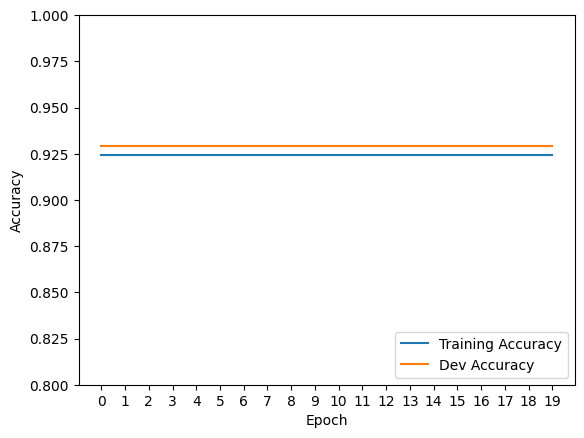

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Dev Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.xticks(range(EPOCH_SIZE))
plt.legend(loc='lower right')
plt.savefig('../../result/cnn_model/crude_accuracy.png', format='png')
plt.show();

Training Loss vs Dev Loss

In [23]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

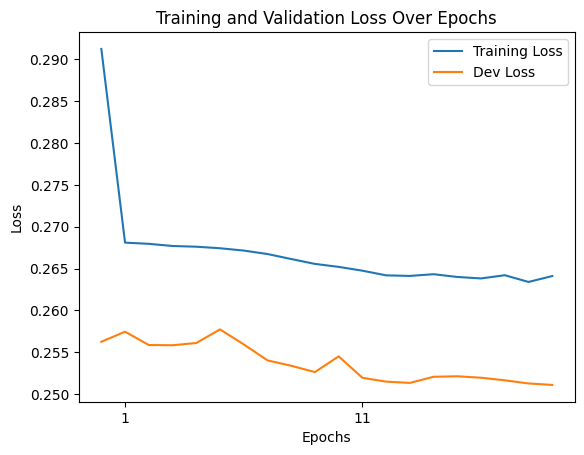

In [24]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.xticks(range(EPOCH_SIZE)) 
plt.savefig('../../result/cnn_model/crude_loss.png', format='png')
plt.show();

In [25]:
# save the trained model
model.save('../../result/cnn_model/crude.h5') 

### ROC curve

In [1]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
y_pred_proba = model.predict(X_dev).ravel()
fpr, tpr, thresholds = roc_curve(Y_dev, y_pred_proba)  # Y_dev contains true labels
roc_auc = roc_auc_score(Y_dev, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../../result/cnn_model/roc_curve.png', format='png', dpi=300)
plt.show()

## Conclusion

In [26]:
gpus = tf.config.list_physical_devices('GPU')
print("Number of GPUs used:", len(gpus))

Number of GPUs used: 1


In [27]:
import pkg_resources

installed_packages = pkg_resources.working_set
for package in installed_packages:
    print(f"{package.key}=={package.version}")

babel==2.14.0
brotli==1.0.9
markdown==3.7
markupsafe==3.0.2
pyqt5==5.15.10
pyqt5-sip==12.13.0
pysocks==1.7.1
pyyaml==6.0.2
qtpy==2.4.1
send2trash==1.8.3
absl-py==2.1.0
anaconda-anon-usage==0.4.4
anyio==4.6.2.post1
archspec==0.2.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
attrs==24.2.0
beautifulsoup4==4.12.3
bleach==6.1.0
boltons==23.0.0
cached-property==1.5.2
certifi==2024.8.30
cffi==1.17.1
charset-normalizer==3.3.2
comm==0.2.2
conda==24.9.2
conda-content-trust==0.2.0
conda-libmamba-solver==24.9.0
conda-package-handling==2.3.0
conda-package-streaming==0.10.0
contourpy==1.3.0
cryptography==43.0.0
cycler==0.12.1
debugpy==1.8.7
decorator==5.1.1
defusedxml==0.7.1
distro==1.9.0
entrypoints==0.4
exceptiongroup==1.2.2
executing==2.1.0
fastjsonschema==2.20.0
flatbuffers==24.3.25
fonttools==4.54.1
fqdn==1.5.1
frozendict==2.4.2
gast==0.6.0
google-pasta==0.2.0
grpcio==1.67.1
h11==0.14.0
h2==4.1.0
h5py==3.12.1
hpack==4.0.0
htt

/tmp/ipykernel_2171/3885190956.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
